In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Interpolation function

In [2]:
def interp(im,x,y): # a function to interpolate the image pixel value at coordinates x,y
    
    #Finding the points surrounding the passed points 
    x1 = np.floor(x).astype(int) #flooring the point to find the minimum
    x2 = x1 + 1 #adding 1 to find the maximum 
    y1 = np.floor(y).astype(int)
    y2 = y1 + 1
    
    
    #finding the 2x2 functions array, and a x and y array
    funcs = np.array(([im[y1,x1,1], im[y1,x2,1]],[im[y2,x1,1], im[y2,x2,1]]))
    x_arr = np.array(([x2 - x, x - x1]))
    y_arr = np.array(([y2 - y, y - y1]))
    
    #Performing the matrix multiplication 
    value = np.matmul(np.matmul(x_arr,funcs),np.transpose(y_arr))
    
    return value

Import the images 

In [3]:
imageL = cv2.imread('left.jpg')
imageR = cv2.imread('right.jpg')

# creating the homography matrix 
H = np.array(([1.6010, -0.0300, -317.9341], [0.1279, 1.5325, -22.5847],[0.0007, 0, 1.2865]))

Image stitching 

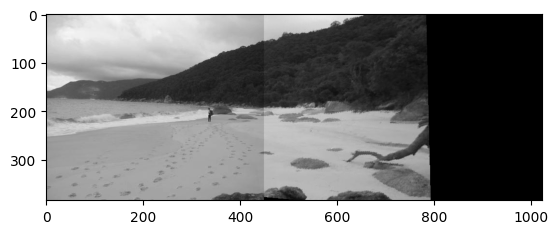

In [4]:
#Creating the stitch image array, then placing the left image on the left side 
stitch = np.zeros([384, 1024])
stitch[:,:512] = imageL[:,:,0]

#adjustment to the border of border, which is part of the blending of the image in part 5 
border = 450

#finding the width and height of the stitch image and the right image 
sH, sW = stitch.shape
rH, rW, rD = imageR.shape

#Nested for loop to go through every desired point for the stitiching 
for y in range(sH):
    for x in range(sW-border):
        curr = [x + border,y,1] #array for the current point for matrix multiplication 
        #Finding the translated point with matrix multiplication 
        tran = np.matmul(H,np.transpose(curr))
        
        #If statement to check if the translated point does lie within the right image bounds
        if (0<=tran[0]/tran[2]<rW-1) and (0<=tran[1]/tran[2]<rH-1):
            stitch[y, x + border] = interp(imageR,tran[0]/tran[2],tran[1]/tran[2])#If it does interpolate the point
        else:
            stitch[y, x + border] = 0 #If it doesn't set to 0


            
plt.imshow(stitch, cmap = 'gray')
plt.show()

Better Blending 

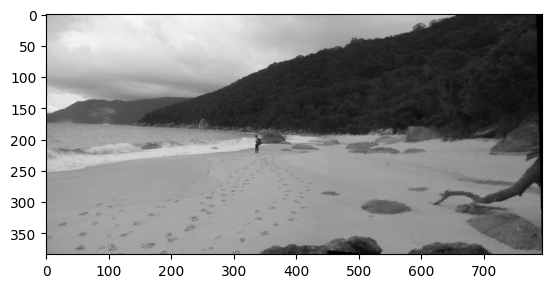

In [5]:
sH, sW = stitch.shape

#for loop to cut out the black sections, based on the first all black column 
for i in range(sW):
    col = stitch[:,i]
    if sum(col) == 0:
        final = stitch[:,:i]
        break

#intensity factor
factor = 0.83

#for loop to go through and adjust the intensity of the pixels on the right of the seem
for y in range(384):
    for x in range(border,final.shape[1]):
        final[y,x] = factor*final[y,x]
        
#Applying a Gaussian blur to the seem of the image to blend it better 
blur = cv2.GaussianBlur(final[:,445:455],[9,3], cv2.BORDER_DEFAULT)
final[:,445:455] = blur

plt.imshow(final, cmap = 'gray')  
plt.show()